### Import packages and set paths

In [1]:
#Import packages
from copy import deepcopy
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx  
import numpy as np
import os
import pandas as pd
import pickle
import pytz
import simpy
import xarray as xr
from matplotlib.gridspec import GridSpec

#Import packages OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel as vessel_
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor

%load_ext autoreload
%autoreload 2

In [2]:
output_path = os.getcwd()
path = output_path.split('\\04_Output_data')[0]

### Functions

In [3]:
def calculate_ship_percentage(origin_destination_matrix,lenght_min,lenght_max,draught_min,draught_max,direction):
    """ 
    Function that calculates the percentage of vessels of a certain dimensions and directions
    
    Parameters
    ----------
    origin_destination_matrix: pandas dataframe of the vessels of call with 'length', 'draught', and '(un)loading'
    lenght_min: minimum length of the vessel
    lenght_max: maximum length of the vessel
    draught_min: minimum draught of the vessel
    draught_max: maximum draught of the vessel
    direction: direction of the vessel as a string: 'inbound' or 'outbound'
    
    :returns: percentage of vessels based on the criteria as a float
    """
    
    origin_destination_matrix = origin_destination_matrix.reset_index(drop=True)
    if direction == 'inbound':
        percentage = len(origin_destination_matrix[(origin_destination_matrix.length >= lenght_min)&
                                                   (origin_destination_matrix.length <= lenght_max)&
                                                   (origin_destination_matrix.draught >= draught_min)&
                                                   (origin_destination_matrix.draught <= draught_max)])/len(origin_destination_matrix)
    else:
        outbound_df = pd.DataFrame([draught-np.sum(unloading) for draught,unloading in zip(origin_destination_matrix.draught.to_numpy(),origin_destination_matrix['(un)loading'])])
        percentage = len(origin_destination_matrix[(origin_destination_matrix.length >= lenght_min)&
                                                   (origin_destination_matrix.length <= lenght_max)&
                                                   (outbound_df[0] > draught_min)&
                                                   (outbound_df[0] <= draught_max)])/len(origin_destination_matrix)
    percentage = np.round(percentage*100,1)
    return percentage

def make_rgb_transparent(rgb, bg_rgb,alpha):
    """ 
    Function that creates a non-transparent color based on a transparent color
    
    Parameters
    ----------
    rgb: RGB-code as a list of RGB numbers from 0.0 to 1.0 as floats
    bg_rgb: background RGB-code as a list of RGB numbers from 0.0 to 1.0 as floats
    alpha: transparency of the RGB-color on the background RGB-color from 0.0 to 1.0 as float
    
    :returns: non-transparent color
    """
    
    non_transparent_color = [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
    
    return non_transparent_color

def calculate_absolute_waiting_times(df):
    """ 
    Function that calculates the total and average waiting times of vessels

    Parameters
    ----------
    df: pandas dataframe of the vessels' output containing the 'Modelled_total_waiting_time'
    
    Returns
    -------
    total_waiting_time: total waiting time
    average_waiting_time: average total waiting time
    """
    
    total_waiting_time = np.sum(df.Modelled_total_waiting_time)
    average_waiting_time = np.mean(df[df.Modelled_total_waiting_time > pd.Timedelta(0,'s')].Modelled_total_waiting_time)
    
    return total_waiting_time,average_waiting_time

def calculate_waiting_time_percentages(full_model_comparison_df,model_no_priority_comparison_df,model_no_tidal_window_comparison_df,cascading=False,observed=True,direct=True):
    """ 
    Function that creates a vessel agent in the nautical traffic model

    Parameters
    ----------
    full_model_comparison_df:
    model_no_priority_comparison_df:
    model_no_tidal_window_comparison_df:
    cascading:
    observed:
    direct:
    
    Returns
    -------
    A list containing the following parameters:
     - unresolved_long_term_waiting_time: timedelta of total unresolved long term waiting time (cause not known)
     - unresolved_short_term_waiting_time: timedelta of total unresolved short term waiting time (cause not known)
     - resolved_long_term_waiting_time_due_to_prioritization: timedelta of total resolved long term waiting time allegedly 
                                                              due to prioritization
     - resolved_short_term_waiting_time_due_to_prioritization: timedelta of total resolved short term waiting time 
                                                               allegedly due to prioritization
     - resolved_waiting_time_due_to_availability: timedelta of total resolved non-cascading waiting time due to terminal 
                                                  congestion
     - resolved_cascading_waiting_time_due_to_prioritization: timedelta of total cascading waiting time allegedly due to
                                                              prioritization
     - resolved_cascading_waiting_time_due_to_tidal_windows: timedelta of total cascading waiting time due to tidal
                                                             restrictions
     - resolved_waiting_time_due_to_tidal_windows: timedelta of total non-cascading waiting time due to tidal windows
    """
    
    
    if observed:  
        relative_df = full_model_comparison_df.Observed_total_waiting_time
    else:
        relative_df = full_model_comparison_df.Modelled_total_waiting_time
    
    if direct:
        difference_df = (relative_df-full_model_comparison_df.Modelled_total_waiting_time)
        unresolved_waiting_time = np.sum(difference_df[difference_df >= np.timedelta64(0,'s')])/(np.sum(relative_df)+pd.Timedelta(1,'s'))
    else:
        unresolved_waiting_time = 1-np.sum(full_model_comparison_df.Modelled_total_waiting_time)/np.sum(relative_df)
    unresolved_df = relative_df-full_model_comparison_df.Modelled_total_waiting_time
    long_discrepancy = unresolved_df - pd.Timedelta(12,'h')
    short_discrepancy = unresolved_df[unresolved_df > pd.Timedelta(0,'h')].sum() - long_discrepancy[long_discrepancy > pd.Timedelta(0,'s')].sum()
    priority_df = full_model_comparison_df.Waiting_due_to_priority_inbound
    priority_long = priority_df[priority_df > pd.Timedelta(12,'h')].sum()/(priority_df.sum()+pd.Timedelta(1,'s'))
    priority_short = 1 - priority_long
    long_term_unresolved = unresolved_df[unresolved_df > pd.Timedelta(12,'h')].sum()/(np.sum(unresolved_df[unresolved_df > pd.Timedelta(0,'h')])+pd.Timedelta(1,'s'))
    short_term_unresolved = unresolved_df[(unresolved_df > pd.Timedelta(0,'h'))&(unresolved_df < pd.Timedelta(12,'h'))].sum()/(np.sum(unresolved_df[unresolved_df > pd.Timedelta(0,'h')])+pd.Timedelta(1,'s'))
    resolved_waiting_time = 1-unresolved_waiting_time
    waiting_time_availability = np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    waiting_time_priority = np.sum(full_model_comparison_df.Waiting_due_to_priority_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    waiting_time_tidal_window = np.sum(full_model_comparison_df.Waiting_for_tidal_window_inbound)/(np.sum(full_model_comparison_df.Modelled_total_waiting_time)+np.timedelta64(1,'s'))
    if cascading:
        mask = full_model_comparison_df.Waiting_due_to_priority_inbound==pd.Timedelta(0,'s')
        df = full_model_comparison_df[mask].Waiting_for_available_berth_inbound-model_no_tidal_window_comparison_df[mask].Waiting_for_available_berth_inbound
        cascading_tidal_window = np.sum(df[df>pd.Timedelta(0,'s')])/(np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)+pd.Timedelta(1,'s'))
        df = full_model_comparison_df[mask].Waiting_for_available_berth_inbound-model_no_priority_comparison_df[mask].Waiting_for_available_berth_inbound
        cascading_priority = np.sum(df[df>pd.Timedelta(0,'s')])/(np.sum(full_model_comparison_df.Waiting_for_available_berth_inbound)+pd.Timedelta(1,'s'))
        non_cascading = 1-cascading_priority-cascading_tidal_window
    else:
        non_cascading = 1
        cascading_priority = 0
        cascading_tidal_window = 0 
        
    unresolved_long_term_waiting_time = unresolved_waiting_time*long_term_unresolved
    unresolved_short_term_waiting_time = unresolved_waiting_time*short_term_unresolved
    resolved_long_term_waiting_time_due_to_prioritization = waiting_time_priority*resolved_waiting_time*priority_long
    resolved_short_term_waiting_time_due_to_prioritization = waiting_time_priority*resolved_waiting_time*priority_short
    resolved_waiting_time_due_to_availability = waiting_time_availability*resolved_waiting_time*non_cascading
    resolved_cascading_waiting_time_due_to_prioritization = waiting_time_availability*resolved_waiting_time*cascading_priority
    resolved_cascading_waiting_time_due_to_tidal_windows = waiting_time_availability*resolved_waiting_time*cascading_tidal_window
    resolved_waiting_time_due_to_tidal_windows = waiting_time_tidal_window*resolved_waiting_time
    
    return [unresolved_long_term_waiting_time,
            unresolved_short_term_waiting_time, 
            resolved_long_term_waiting_time_due_to_prioritization,
            resolved_short_term_waiting_time_due_to_prioritization,
            resolved_waiting_time_due_to_availability,
            resolved_cascading_waiting_time_due_to_prioritization,
            resolved_cascading_waiting_time_due_to_tidal_windows,
            resolved_waiting_time_due_to_tidal_windows]
    

def create_vessel(Vessel,env,name,origin,destination,next_destination,beam,length,draught,delta_draught,berthing_time,unloading_time,turning_time,arrival_time,terminal_of_call,berth_of_call,additional_waiting_time,bound='inbound',height=0.,ukc=0.,max_cross_current=0.):
    """ 
    Function that creates a vessel agent in the nautical traffic model

    Parameters
    ----------
    Vessel: type object element that includes the mixin objects that symbolize a vessel agent
    env: simpy environment
    name: name of the vessel as a string
    origin: origin node of the network as a string
    destination: destination node of the network as a string
    next_destination: list of next destination nodes of the network as a string
    beam: beam of the vessel in meters as a float
    length: length of the vessel in meters as a float
    draught: draught of the vessel in meters as a float
    delta_draught: list of draught changes of the vessel in meters as a float in sequence of terminal visits
    berthing_time: berthing time of the vessel as pandas timestamp
    unloading_time: list of unloading times of the vessel as pandas timestamps in sequence of terminal visits
    turning_time: list of turning times of the vessel as pandas timestamps in sequence of harbour basin visits
    arrival_time: rrival time of vessel as pandas timestamp
    terminal_of_call: list of terminal names as string in sequence of terminal visits
    berth_of_call: list of berth names as string in sequence of terminal visits
    additional_waiting_time: additional waiting time as pandas timedelta
    bound: 'inbound' or 'outbound'
    height: height of the vessel in meters as a float
    ukc: extra required under keel clearance of the vessel in meters as a float
    max_cross_current: additional maximum allowable cross-current velocity of the vessel in meters per second as a float

    :returns: vessel agent
    """
    
    vessel_input = { "name":name,
                     "origin":origin,
                     "destination":destination,
                     "next_destination":next_destination,
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     "t_berthing":berthing_time.total_seconds(),
                     "t_(un)loading":[time.total_seconds() for time in unloading_time],
                     "t_turning":[time.total_seconds() for time in turning_time],
                     "ukc":ukc,
                     "v":np.NaN,
                     "terminal_of_call": terminal_of_call,
                     "berth_of_call": berth_of_call,
                     "(un)loading": delta_draught,
                     "max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     "max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     "arrival_delay":arrival_time,
                     "priority": 0,
                     "additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     "bound":bound,
                     "priority":False}
    
    created_vessel = Vessel(**vessel_input)
    return created_vessel

### Set parameters

In [4]:
simulation_start = datetime.datetime(2019,1,1,0,0,0).replace(tzinfo=pytz.utc)
simulation_stop = datetime.datetime(2020,1,1,0,0,0).replace(tzinfo=pytz.utc)

In [5]:
#Conversion kn to m/s
knots = 0.51444

In [6]:
type_dataframe = pd.DataFrame({'Length':[120,150,180,294,366,400],
                               'Width':[22,24.5,29,32,49,77.5],
                               'Draught':[8.6,9.9,11.2,12,15.2,20.1],
                               'Heigth':[25,30,35,58,58,68],
                               'DWT':[24,35,50,80,100,200]},
                               index=['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'])

### Import vessel speed

In [7]:
with open(path+"\\03_Simulation\\01_Input_data\\03_Vessels\\vessel_speed_dataframe.pickle", "rb") as input_file:
    vessel_speed_dataframe = pickle.load(input_file)

#Add missing vessel speeds and convert to xarray
missing_vessel_speeds = pd.DataFrame([0.1,0.1,5,5],columns=['average_speed'],index=[('anchorage','8866969'),('8866969','anchorage'),('B17838816_B', 'B17838816_A'),('B17838816_A', 'B17838816_B')])
missing_vessel_speeds.index.name = 'edge'
vessel_speed_dataframe = pd.concat([vessel_speed_dataframe,missing_vessel_speeds],axis=0)
vessel_speed_data = vessel_speed_dataframe.to_xarray()

### Import hydrodynamic data

In [10]:
hydrodynamic_data = xr.open_dataset("C:\\users\\floorbakker\\documents\\hydrodynamic_data\\hydrodynamic_data_PoR_stations.nc")

In [11]:
#Overwrite MBLs (Change MBLs here)
node_list = hydrodynamic_data['STATION'].values
hydrodynamic_data['MBL'] = xr.DataArray(23*np.ones(len(node_list)),coords={'STATION':node_list})
for index,node in enumerate(node_list):
    if node in ['8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        hydrodynamic_data['MBL'][index] = 16.2
    elif node in ['8867547','8867980','8866999']:
        hydrodynamic_data['MBL'][index] = 15.9
    elif node in ['8866859']:
        hydrodynamic_data['MBL'][index] = 15.9
    elif node in ['anchorage','8866969']:
        hydrodynamic_data['MBL'][index] = 23.8
    else:
        hydrodynamic_data['MBL'][index] = 16.4

In [12]:
#Possibility to change bed level over time
new_MBLs = np.empty((len(hydrodynamic_data['STATION']),len(hydrodynamic_data['TIME'])))
for station,MBL in enumerate(hydrodynamic_data['MBL'].values):
    for time,_ in enumerate(hydrodynamic_data['TIME'].values):
        new_MBLs[station][time] = MBL
        
new_MBLs = xr.DataArray(new_MBLs,dims=['STATION','TIME'],coords=dict(STATION=hydrodynamic_data['STATION'],
                                                                     TIME=hydrodynamic_data['TIME']))

hydrodynamic_data['MBL'] = new_MBLs

In [13]:
#Read tidal period data
for tide_type,dim_name in zip(['Vertical tidal periods','Horizontal tidal periods'],['VERTICALTIDES','HORIZONTALTIDES']):
    data = np.empty(hydrodynamic_data[tide_type].values.shape[:2], dtype=[('a','datetime64[ns]'),('b',object)])
    tide_info = hydrodynamic_data[tide_type].values
    for station_index,_ in enumerate(hydrodynamic_data.STATION.values):
        for tide_index in hydrodynamic_data[dim_name].values:
            time = tide_info[station_index][tide_index][0]
            tide = tide_info[station_index][tide_index][1]
            if time == 'nan':
                new_time = 'NaT'
            else:
                new_time = time
            data[station_index][tide_index] = (np.datetime64(new_time),tide)
    
    final_data = []
    for i,_ in enumerate(data):
        final_data.append([])
        final_data[-1].append([])
        for j,_ in enumerate(data[0]):
            final_data[-1][-1].append([data[i][j][0],data[i][j][1]])
    hydrodynamic_data[tide_type].data = np.array(final_data).squeeze()

### Import network

In [14]:
with open(path+"\\03_Simulation\\01_Input_data\\01_Geospatial_data\\network\\PortNetwork.pickle", 'rb') as f:
    FG = pickle.load(f)

### Create environment

In [15]:
env = simpy.Environment()
env.simulation_start = simulation_start
env.simulation_stop = simulation_stop
env.FG = FG
env.vessel_traffic_service = vessel_traffic_service.VesselTrafficService(env=env,
                                                                         hydrodynamic_data=hydrodynamic_data,
                                                                         vessel_speed_data=vessel_speed_data)

### Set tidal window restrictions on the network

In [16]:
#Restrictions as dictionaries
for node in env.FG.nodes:
    env.FG.nodes[node]['Vertical tidal restriction'] = {}
env.FG.nodes['8861158']['Horizontal tidal restriction'] = {}

In [17]:
network_properties = tidal_window_constructor.NetworkProperties()

In [18]:
#According to Port of Rotterdam vertical tidal windows policy (Change here the ukc policy)
ukc_p = []
ukc_s = []
fwa = []
        
for index,node in enumerate(env.FG.nodes):
    if node in ['8866969','8866305','8864266','8862925','8864465','S14716_B','S14716_A','8860845']:
        ukc_s.append(0.)
        ukc_p.append(0.1)
        fwa.append(0.01)
    elif node in ['8867547','8867980','8866999']:
        ukc_s.append(1.0)
        ukc_p.append(0.0)
        fwa.append(0.025)
    elif node in ['8866859']:
        ukc_s.append(0.5)
        ukc_p.append(0.0)
        fwa.append(0.0)
    elif node in ['anchorage']:
        ukc_s.append(0.0)
        ukc_p.append(0.0)
        fwa.append(0.0)
    else:
        ukc_s.append(0.0)
        ukc_p.append(0.1)
        fwa.append(0.025)
        
for index,node in enumerate(env.FG.nodes):
    vertical_tidal_window_inputs = []

    #Inbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)
    
    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    #Outbound_Vessels_Condition
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 0},
                                                                           'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.vertical_tidal_window_specifications(ukc_s = ukc_s[index],
                                                                                         ukc_p = ukc_p[index],
                                                                                         fwa = fwa[index],)

    vertical_tidal_window_inputs.append(tidal_window_constructor.vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                             window_specifications = window_specification))

    network_properties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

In [19]:
#Port of Rotterdam Horizontal tidal windows policy 3rd Petroleum Harbour
previous_nodes = ['8861716','8861674']
node = '8861158'
next_node = '8867547'
knots = 0.5144444
horizontal_tidal_window_inputs = []
scheurkade_data = hydrodynamic_data.sel({'STATION':'Scheurkade'})
scheurkade_data['TIME'] = scheurkade_data.TIME.values - np.timedelta64(20,'m')

for previous_node in previous_nodes:
    #Inbound_Vessels_Condition1
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Length: 180,
                                                                           rule_constructor.vessel_characteristics.min_ge_Draught: 11.0, #11.0
                                                                           rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           '(x and x and x)',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value: 2*knots})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))
    #Inbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3},
                                                  'x',rule_constructor.vessel_direction.inbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': previous_node, 'Destination': next_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition1  
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Length: 200,
                                                                           rule_constructor.vessel_characteristics.min_ge_Draught: 12.0, #12.0
                                                                           rule_constructor.vessel_characteristics.max_lt_Draught: 14.3},
                                                                           '(x and x and x)',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.maximum.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: 2*knots,tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.accessible.value})


    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

    #Outbound_Vessels_Condition2
    vessel_specification = tidal_window_constructor.vessel_specifications({rule_constructor.vessel_characteristics.min_ge_Draught: 14.3}, #14.3
                                                  'x',rule_constructor.vessel_direction.outbound.value)

    window_specification = tidal_window_constructor.horizontal_tidal_window_specifications(tidal_window_constructor.horizontal_tidal_window_method.point_based.value,
                                                                                           {tidal_window_constructor.tidal_period.Flood.value: [1.3*0.5*knots,0.7*0.5*knots],tidal_window_constructor.tidal_period.Ebb.value:tidal_window_constructor.accessibility.inaccessible.value})

    horizontal_tidal_window_inputs.append(tidal_window_constructor.horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                                                 window_specifications = window_specification,
                                                                                                 condition = {'Origin': next_node, 'Destination': previous_node},
                                                                                                 data = scheurkade_data))

network_properties.append_horizontal_tidal_restriction_to_network(FG,node,horizontal_tidal_window_inputs)

[]
['>=']
['>=', '>=']
[]
[]
['>=']
['>=', '>=']
[]
[]
['>=']
['>=', '>=']
[]
[]
['>=']
['>=', '>=']
[]


### Import origin destination matrix

In [21]:
with open(path+'\\02_Data_Processing\\01_AIS_data\origin_destination_matrix.pickle','rb') as handle: #model_no_tidal_window
    origin_destination_matrix = pickle.load(handle)

<>:1: DeprecationWarning:

invalid escape sequence \o

<>:1: DeprecationWarning:

invalid escape sequence \o

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_86992\3979668040.py:1: DeprecationWarning:

invalid escape sequence \o



### Create vessels

In [22]:
#Create vessels
list_of_vessels = []
for loc,info in origin_destination_matrix.iterrows():
    Vessel = type('Vessel', (vessel_.IsVessel,
                             port.HasPortAccess, 
                             port.HasAnchorage, 
                             port.HasTurningBasin, 
                             port.HasTerminal), {})
    if info.origin_node in ['8868178','8866859','8866999']:
        bound = 'outbound'
    else:
        bound = 'inbound'

    created_vessel = create_vessel(Vessel,
                                   env=env,
                                   name=info['name'],
                                   origin=info['origin_node'],
                                   destination=info['berth_node'][0],
                                   next_destination=np.append([],info['destination_node']),
                                   beam=info['width'],
                                   length=info['length'],
                                   draught=info['draught'],
                                   delta_draught=np.append([],info['(un)loading']),
                                   berthing_time=pd.Timedelta(1,'s'),
                                   unloading_time=np.append([],info['(un)loading time']),
                                   turning_time= [pd.Timedelta(0,'s')], #np.append([],info['turning_time'][0]),
                                   arrival_time=info['arrival']+pd.Timedelta(1,'h'),
                                   terminal_of_call=np.array(['Koole' for i in range(len(list(info['berth_of_call'])))]),
                                   berth_of_call=np.array(info['berth_of_call']),
                                   additional_waiting_time = pd.Timedelta(0,'s'),
                                   bound=bound)
    list_of_vessels.append(created_vessel)

### Import simulation results

In [23]:
with open(output_path+'\\01_Simulation_results\\model_outcome_base.pickle','rb') as handle: #full_model
    full_model_comparison_df = pickle.load(handle)
    
with open(output_path+'\\01_Simulation_results\\model_without_turning.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_without_turning = pickle.load(handle)
    
with open(output_path+'\\01_Simulation_results\\model_outcome_no_priority_no_tidal_window.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_no_priority_no_tidal_window_comparison_df = pickle.load(handle)   
    
with open(output_path+'\\01_Simulation_results\\model_with_shallowing.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_with_shallowing = pickle.load(handle)   
    
with open(output_path+'\\01_Simulation_results\\model_without_long_laytimes.pickle','rb') as handle: #model_no_priority_no_tidal_window
    model_without_long_laytimes = pickle.load(handle)
    
with open(output_path+'\\01_Simulation_results\\model_outcome_no_priority.pickle','rb') as handle: #model_no_priority
    model_no_priority_comparison_df = pickle.load(handle)
    
with open(output_path+'\\01_Simulation_results\\model_outcome_no_tidal_window.pickle','rb') as handle: #model_no_tidal_window
    model_no_tidal_window_comparison_df = pickle.load(handle)    

### Derive shiptype dataframe

In [24]:
ship_types = {}
for row,trip_info in origin_destination_matrix.iterrows():
    for ship_type,ship_dimensions in type_dataframe.iterrows():
        if trip_info.length <= ship_dimensions.Length and trip_info.width <= ship_dimensions.Width and trip_info.draught <= ship_dimensions.Draught:
            ship_types[trip_info.trip_id] = ship_type
            break
shiptype_df = pd.DataFrame.from_dict(ship_types, orient='index', columns=['Shiptype'])

## Figure 07

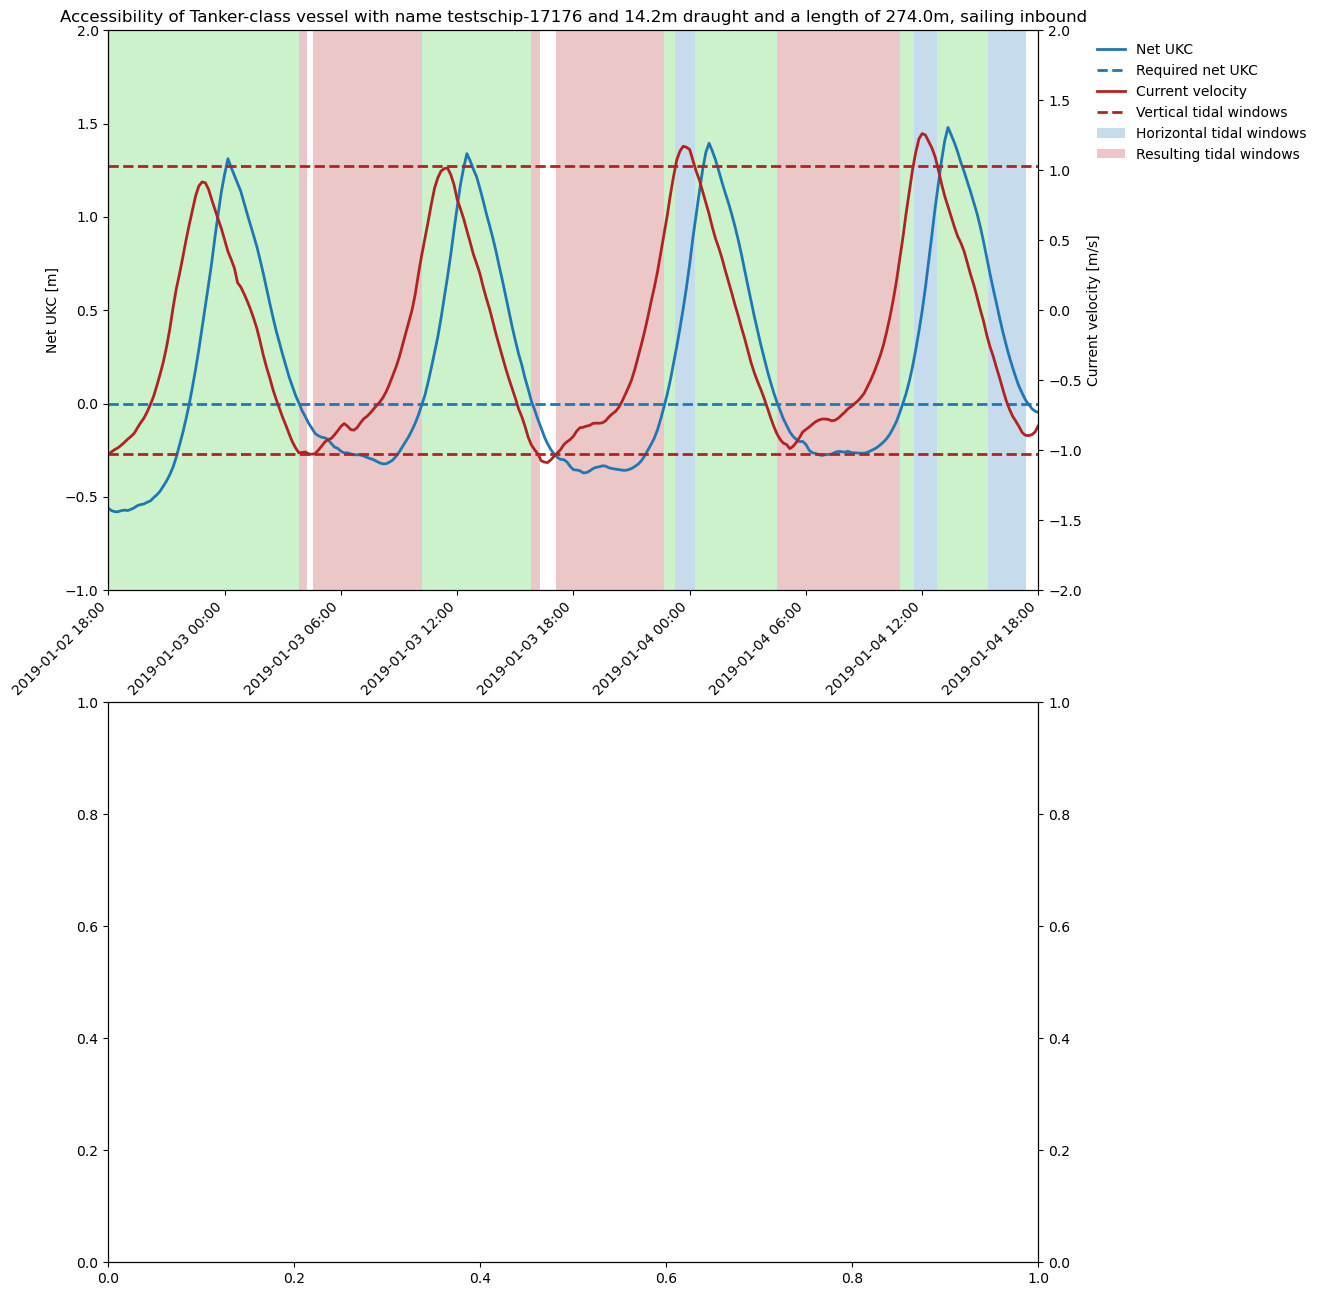

In [45]:
fig,axes = plt.subplots(2,1,figsize=[12,16])
mpl.rcParams['axes.unicode_minus'] = True
ax_left1 = axes[0]
ax_right1 = ax_left1.twinx()
ax_left2 = axes[1]
ax_right2 = ax_left2.twinx()

vessel = list_of_vessels[274]
vessel._T = 14.2
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
_,_,ax_left1,ax_right1 = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                            route = vessel.route,ax_left=ax_left1,ax_right=ax_right1,
                                                            time_start = pd.Timestamp('2019-01-02 18:20').to_datetime64(),
                                                            time_end =  pd.Timestamp('2019-01-05').to_datetime64(),
                                                            plot=True)

vessel = list_of_vessels[274]
vessel._T = 15.0
vessel.bound = 'inbound'
vessel.route = nx.dijkstra_path(FG,'8866969','8866999',)
_,_,ax_left2,ax_right2 = vessel.env.vessel_traffic_service.provide_tidal_windows(vessel = vessel,
                                                            route = vessel.route,ax_left=ax_left2,ax_right=ax_right2,
                                                            time_start = pd.Timestamp('2019-01-02 18:20').to_datetime64(),
                                                            time_end =  pd.Timestamp('2019-01-05').to_datetime64(),
                                                            plot=True)


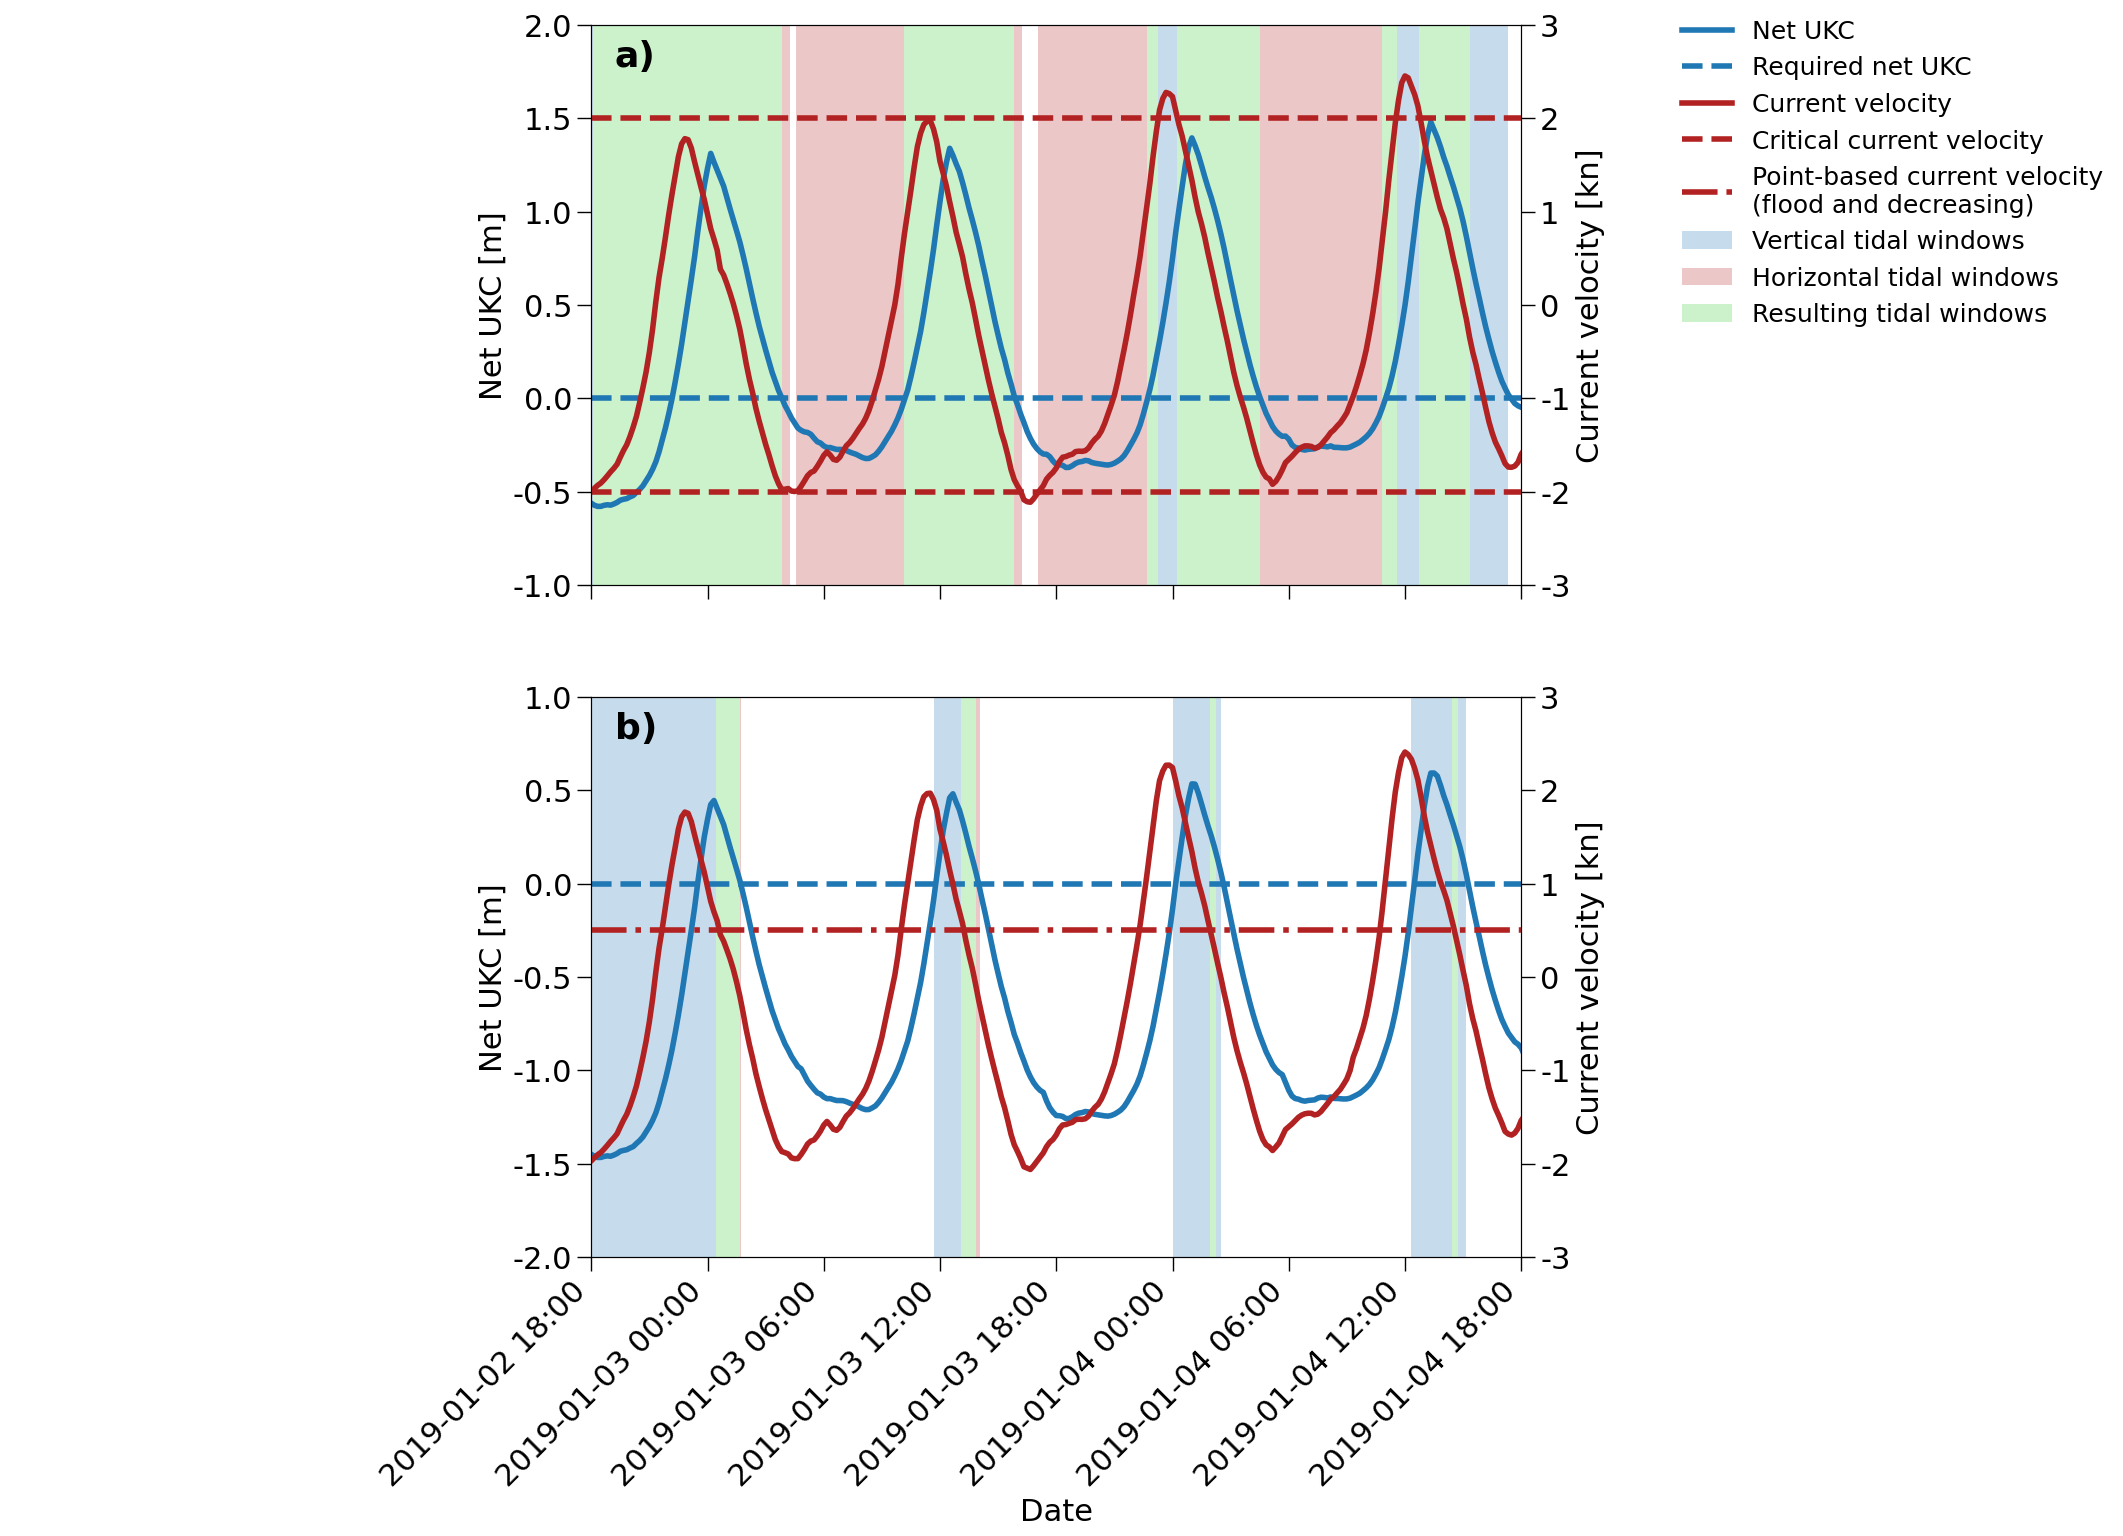

In [46]:
xlabels = ax_left1.get_xticklabels()
labels = deepcopy(xlabels)

ax_left = ax_left1
ax_right = ax_right1
ax_left.set_title('')
lines = list(ax_left.get_lines())
for line in lines:
    line.set_linewidth(4)
lines = list(ax_right.get_lines())
for index,line in enumerate(lines):
    line.set_linewidth(4)
    x_data = []
    y_data = []
    for x,y in line.get_xydata():
        x_data.append(x)
        y_data.append(y/knots)
    if index:
        ax_right.axhline(y/knots,color='firebrick',linewidth=4,linestyle='--')
    else:
        ax_right.plot(x_data,y_data,color='firebrick',linewidth=4)
    line.remove()

xticks = ax_left.get_xticks()
yticks = ax_left.get_yticks()
ylabels = ax_left.get_yticklabels()
ax_left.set_xticks(xticks,width=20)
ax_left.set_xticklabels([])
ax_left.set_xlabel([])
ax_left.set_yticks(yticks)
ax_left.set(xlabel=None)
ax_left.xaxis.set_tick_params(width=1,length=10)
ax_left.yaxis.set_tick_params(width=1,length=10)
ax_right.yaxis.set_tick_params(width=1,length=10)
ax_left.set_yticks(np.arange(-1,2+0.5,0.5))
ax_left.set_yticklabels(np.arange(-1,2+0.5,0.5),fontsize=22)
ax_left.set_yticklabels(ylabels,fontsize=22)
ax_left.set_ylabel('Net UKC [m]',fontsize=22)
ax_right.set_ylabel('Current velocity [kn]',fontsize=22)
ax_right.set_ylim(-3,3)
ax_right.set_yticks(np.arange(-3,3+1,1))
ax_right.set_yticklabels(np.arange(-3,3+1,1),fontsize=22)
legend = ax_left.get_legend()
legend.set_bbox_to_anchor([1.1,1.025])
lines_patches = list(legend.get_lines())
legend.remove()

ax_left = ax_left2
ax_right = ax_right2

ax_left.set_title('')
lines = list(ax_left.get_lines())
for line in lines:
    line.set_linewidth(4)
lines = list(ax_right.get_lines())
for index,line in enumerate(lines):
    line.set_linewidth(4)
    x_data = []
    y_data = []
    for x,y in line.get_xydata():
        x_data.append(x)
        y_data.append(y/knots)
    if index:
        ax_right.axhline(y/knots,color='firebrick',linewidth=4,linestyle='--')
    else:
        ax_right.plot(x_data,y_data,color='firebrick',linewidth=4)
    line.remove()

xticks = ax_left.get_xticks()
yticks = ax_left.get_yticks()
ylabels = ax_left.get_yticklabels()
ax_left.set_yticks(np.arange(-2,1+0.5,0.5))
ax_left.set_yticklabels(np.arange(-2,1+0.5,0.5),fontsize=22)
ax_left.set_xticks(xticks)
ax_left.set_xticklabels(labels,fontsize=22,rotation=45,color='k')
ax_left.set_xlabel('Date',fontsize=22)
ax_left.xaxis.set_tick_params(width=1,length=10)
ax_left.yaxis.set_tick_params(width=1,length=10)
ax_right.yaxis.set_tick_params(width=1,length=10)
ax_left.set_ylabel('Net UKC [m]',fontsize=22)
ax_right.set_ylabel('Current velocity [kn]',fontsize=22)
ax_right.set_ylim(-3,3)
ax_right.set_yticks(np.arange(-3,3+1,1))
ax_right.set_yticklabels(np.arange(-3,3+1,1),fontsize=22)
legend = ax_left.get_legend()
lines_patches.extend(list(legend.get_patches()))
targ = ax_right2.axhline(0.5,color='firebrick',linewidth=4,linestyle='-.')
for handle in lines_patches:
    handle.set_linewidth(4)
lines_patches.insert(4,targ)
ax_left1.legend(lines_patches,['Net UKC','Required net UKC','Current velocity','Critical current velocity',
                               'Point-based current velocity\n(flood and decreasing)','Vertical tidal windows','Horizontal tidal windows',
                               'Resulting tidal windows'],
               frameon=False,
               prop={'size':18},
               loc='upper right',
               bbox_to_anchor=[1.65,1.05])

patches1 = list(legend.get_patches())
ax_left1.text(0.025,0.925,'a)', weight='bold', fontsize=26, transform=ax_left1.transAxes)
ax_left2.text(0.025,0.925,'b)', weight='bold', fontsize=26, transform=ax_left2.transAxes)
ax_left.text(-0.625,0.925,' ', fontsize=26, transform=ax_left1.transAxes)
ax_left2.legend().remove()
fig

In [48]:
fig.savefig(output_path+'\\02_Figures'+'\\Figure_07_Tidal_windows_examples.pdf',format='pdf', dpi=1000,bbox_inches='tight',facecolor="none");

## Figure 08

In [ ]:
length = origin_destination_matrix.length.to_numpy()
inbound_draught = origin_destination_matrix.draught.to_numpy()
outbound_draught = [draught-np.sum(unloading) for draught,unloading in zip(origin_destination_matrix.draught.to_numpy(),origin_destination_matrix['(un)loading'])]

In [ ]:
fig,axes = plt.subplots(1,2,figsize=[9,3],gridspec_kw={'width_ratios': [3,3]})

no_tidal_window, = axes[0].fill([0,300,300,180,180,0],[0,0,11,11,13,13],facecolor='lightgreen',alpha=0.75)
horizontal_tidal_window, = axes[0].fill([180,300,300,180],[11,11,13,13],facecolor='lightcoral',alpha=0.5)
axes[0].fill([180,300,300,180],[13,13,14.3,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.5),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//",linewidth=0)
horizontal_tidal_point, = axes[0].fill([0,0,0,0],[0,0,0,0],facecolor='lightcoral',alpha=0.75)
axes[0].fill([0,0,300,300],[14.3,16,16,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.75),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//",linewidth=0)
vertical_tidal_window, = axes[0].fill([0,180,180,0],[14.3,14.3,13,13],facecolor='C0',alpha=0.75)
axes[0].scatter(length,inbound_draught,zorder=100,color='k',s=25,alpha=0.6,edgecolor="none")
axes[0].set_xlim(0,300)
axes[0].set_ylim(0,16)
axes[0].set_xlabel('Vessel length [m]',fontsize=9)
axes[0].set_ylabel('Draught [m]',fontsize=9)
axes[0].set_yticks(np.arange(0,17,5))
axes[0].set_yticks(np.arange(0,17,1), minor = True)
axes[0].set_title('Inbound vessels',fontsize=10);

axes[1].fill([0,300,300,200,200,0],[0,0,12,12,13,13],facecolor='lightgreen',alpha=0.75)
axes[1].fill([200,300,300,200],[13,13,14.3,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.5),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//",linewidth=0)
horizontal_tidal_point, = axes[0].fill([0,0,0,0],[0,0,0,0],facecolor='lightcoral',alpha=0.75)
axes[1].fill([0,0,300,300],[14.3,16,16,14.3],
             edgecolor=make_rgb_transparent(mpl.colors.to_rgb('lightcoral'),mpl.colors.to_rgb('w'),0.75),
             facecolor=make_rgb_transparent(mpl.colors.to_rgb('C0'),mpl.colors.to_rgb('w'),0.75),
             hatch="//",linewidth=0)
axes[1].fill([200,300,300,200],[12,12,13,13],facecolor='lightcoral',alpha=0.5)
axes[1].fill([0,200,200,0],[14.3,14.3,13,13],facecolor='C0',alpha=0.75)
axes[1].scatter(length,outbound_draught,zorder=100,color='k',s=25,alpha=0.6,edgecolor="none")
axes[1].set_xlim(0,300)
axes[1].set_ylim(0,16)
axes[1].set_xlabel('Vessel length [m]',fontsize=9)
axes[1].set_yticks(np.arange(0,17,5))
axes[1].set_yticks(np.arange(0,17,1), minor = True)
axes[1].set_yticklabels([])
axes[1].set_title('Outbound vessels',fontsize=10)
mpl.rcParams['hatch.linewidth'] = 4
v = axes[0].scatter([-1],[-1],s=20,color='k')
plt.legend([no_tidal_window,vertical_tidal_window,horizontal_tidal_window,horizontal_tidal_point,v],
           ['No tidal window',
            'Vertical tidal window',
            'Horizontal tidal window\n(critical velocity)',
            'Horizontal tidal window\n(point-based)',
            'Vessel'],bbox_to_anchor=[1,1.05],prop={'size':9},frameon=False)
axes[0].text(0.025,0.925,'a)', weight='bold', fontsize=12, transform=axes[0].transAxes)
axes[1].text(0.025,0.925,'b)', weight='bold', fontsize=12, transform=axes[1].transAxes)
axes[0].text(150,15,str(calculate_ship_percentage(origin_destination_matrix,200,300,14.3,16,'inbound'))+'%',fontsize=12,va='center')
axes[0].text(200,13.6,str(calculate_ship_percentage(origin_destination_matrix,200,300,13,14.2,'inbound'))+'%',fontsize=12,va='center')
axes[0].text(200,12.0,str(calculate_ship_percentage(origin_destination_matrix,180,300,11,12.9,'inbound'))+'%',fontsize=12,va='center')
axes[0].text(150,3.0,str((calculate_ship_percentage(origin_destination_matrix,0,300,0,10.9,'inbound')+
                          calculate_ship_percentage(origin_destination_matrix,0,179,11,12.9,'inbound')))+'%',fontsize=12,va='center')
axes[0].text(100,13.6,str(calculate_ship_percentage(origin_destination_matrix,0,199,13,14.2,'inbound'))+'%',fontsize=12,va='center')
axes[1].text(150,15,str(calculate_ship_percentage(origin_destination_matrix,200,300,14.3,16,'outbound'))+'%',fontsize=12,va='center')
axes[1].text(200,13.6,str(calculate_ship_percentage(origin_destination_matrix,200,300,13,14.2,'outbound'))+'%',fontsize=12,va='center')
axes[1].text(200,12.5,str(calculate_ship_percentage(origin_destination_matrix,200,300,12,12.9,'outbound'))+'%',fontsize=12,va='center')
axes[1].text(150,3.0,str((calculate_ship_percentage(origin_destination_matrix,0,300,0,11.9,'outbound')+
                          calculate_ship_percentage(origin_destination_matrix,0,199,12,13.9,'outbound')))+'%',fontsize=12,va='center')
axes[1].text(100,13.6,str(calculate_ship_percentage(origin_destination_matrix,0,199,13,14.2,'outbound'))+'%',fontsize=12,va='center')
plt.subplots_adjust(wspace=0.1)

In [ ]:
fig.savefig(output_path+'\\02_Figures'+'\\Figure_08_Tidal_windows_examples.pdf',format='pdf', dpi=1000,bbox_inches='tight',facecolor="none");

## Figure 09

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_86992\2412786691.py:128: UserWarning:

FixedFormatter should only be used together with FixedLocator



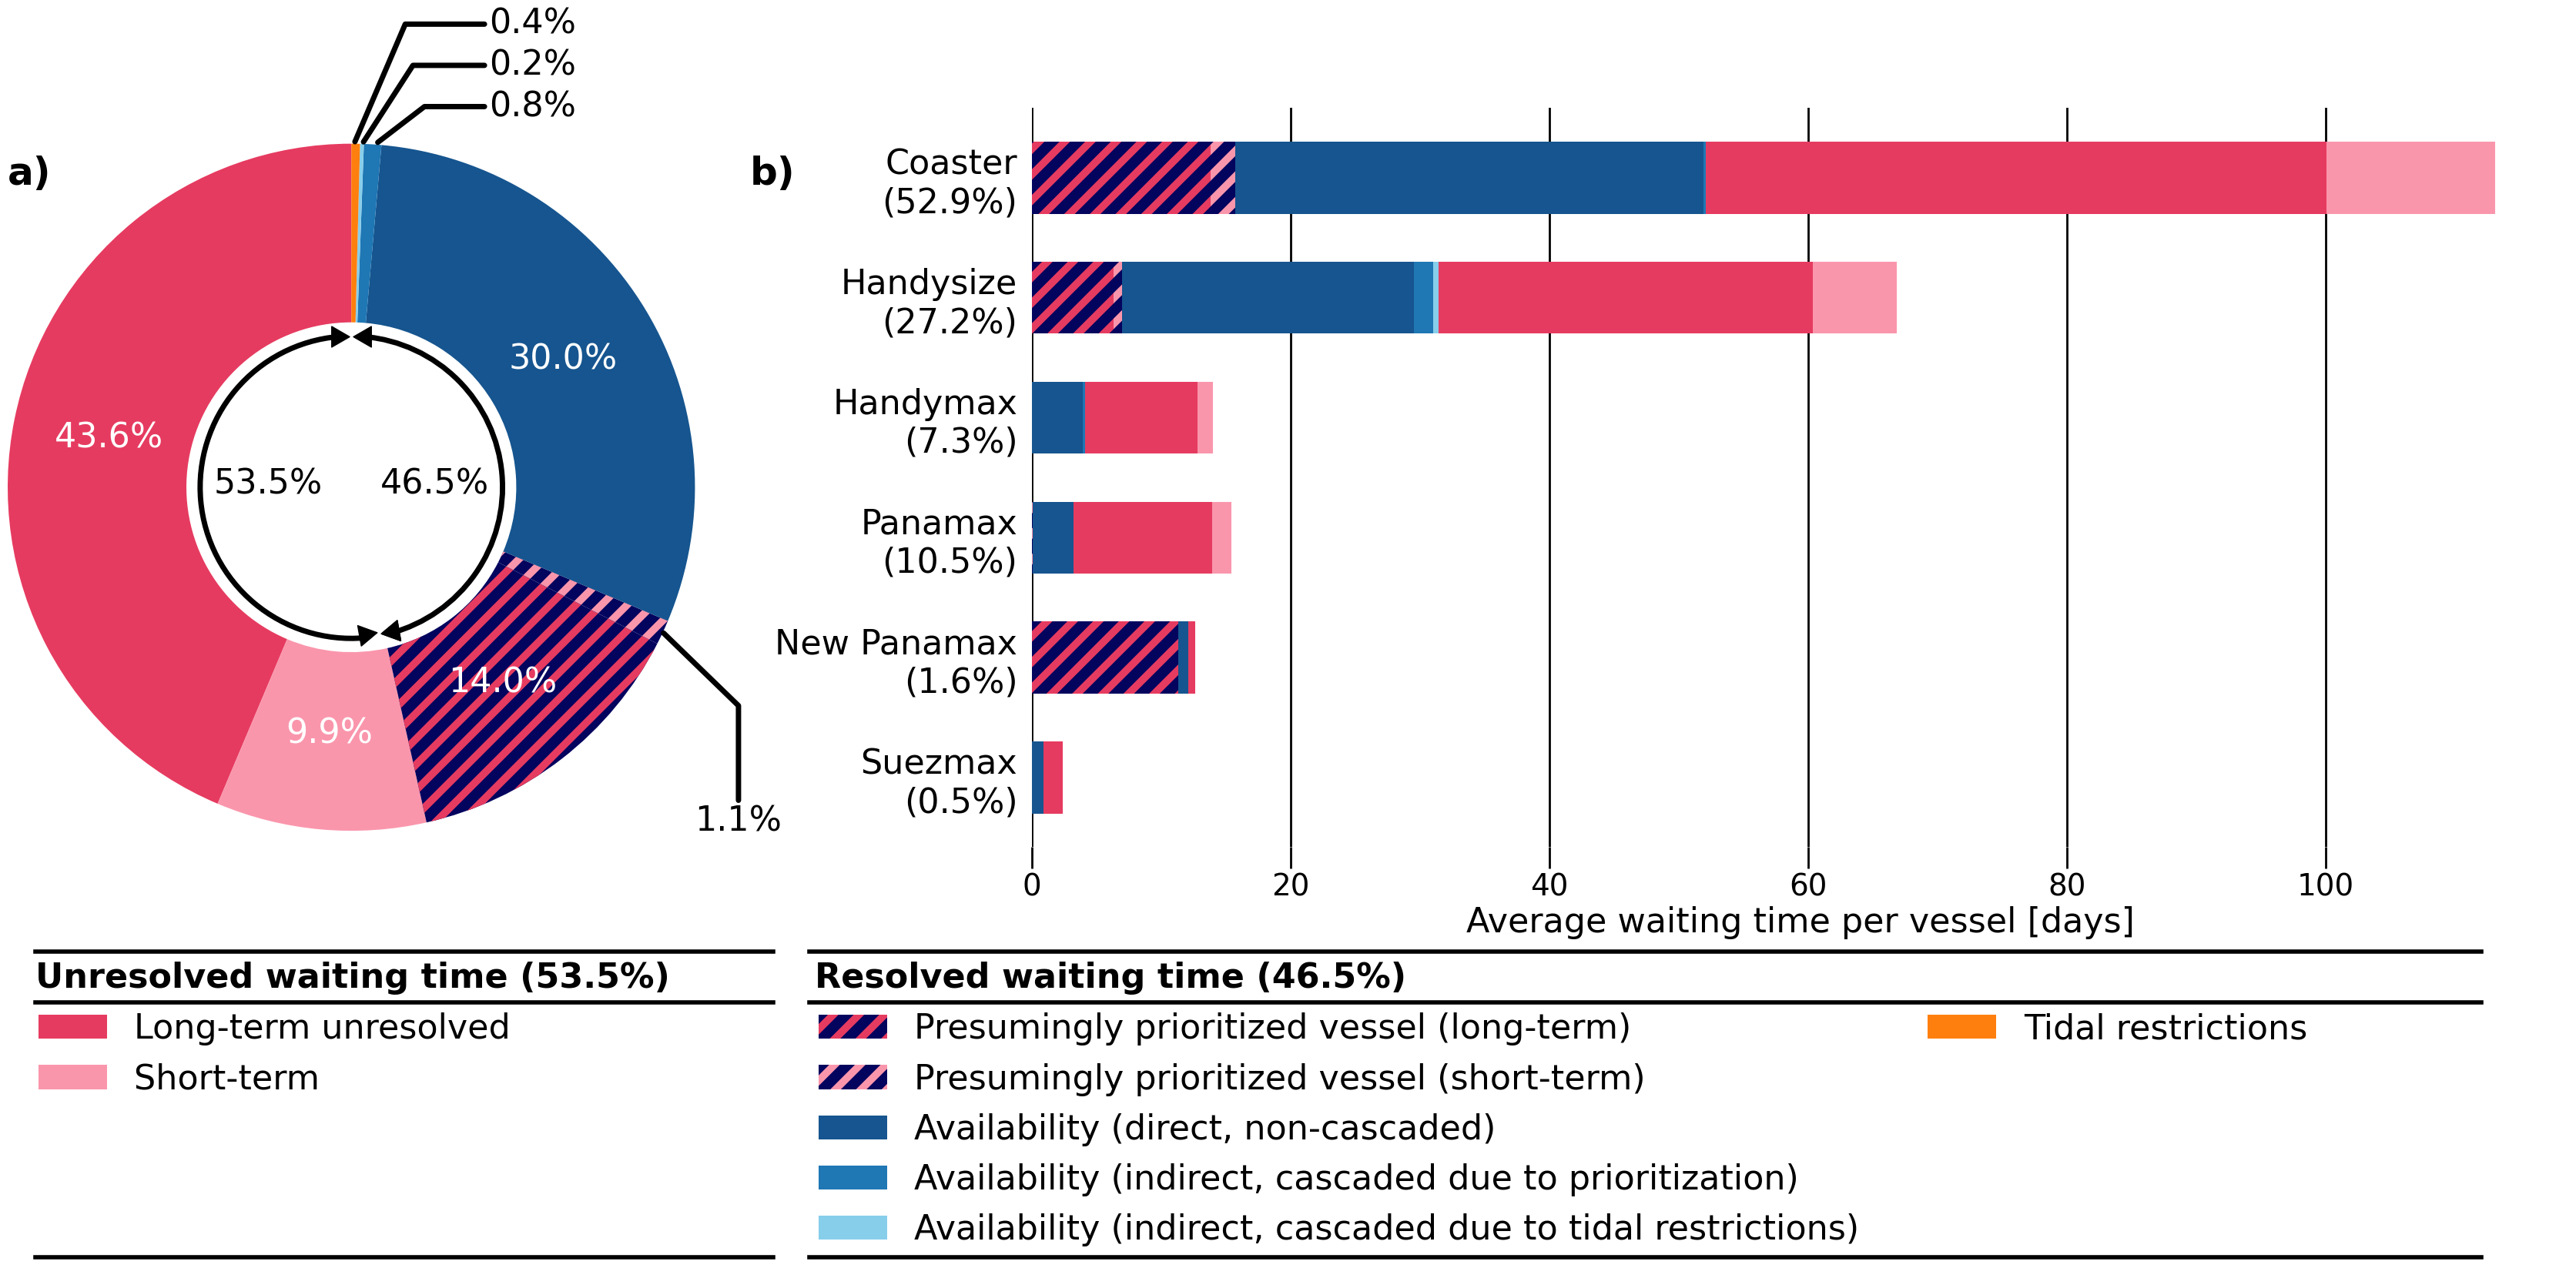

In [68]:
fig, ax = plt.subplots(1,2,figsize=(38, 12),gridspec_kw={'width_ratios':[1,2]},facecolor="none")
ax[1].set_facecolor('none')
data = calculate_waiting_time_percentages(full_model_comparison_df,
                                          model_no_priority_comparison_df,
                                          model_no_tidal_window_comparison_df,
                                          cascading=True)

labels = ['Long-term unresolved                      ',
          'Short-term                                ',
          'Presumingly prioritized vessel (long-term)',
          'Presumingly prioritized vessel (short-term)',
          'Availability (direct, non-cascaded)',
          'Availability (indirect, cascaded due to prioritization)',
          'Availability (indirect, cascaded due to tidal restrictions)',
          'Tidal restrictions']

colors = ['#e63b60','#fa96ac','#03045e','#03045e','#16558F','C0','skyblue','C1']
edgecolors = ['none','none','#e63b60','#fa96ac','none','none','none','none']
text_colors = ['w','w','w','w','w','k','k','k']

ax[0].set_aspect('equal')
wedges, texts, percs = ax[0].pie(data, startangle=90,colors=colors,radius=1.25,center=(0,-0.15),
                                 wedgeprops=dict(width=0.65),autopct="%1.1f%%")

mpl.rcParams['hatch.linewidth'] = 7
wedges[2].set_hatch('/')
wedges[2].set_edgecolor('#e63b60')
wedges[2].set_linewidth(0)
wedges[3].set_hatch('/')
wedges[3].set_edgecolor('#fa96ac')
wedges[3].set_linewidth(0)
groups = [[0,1], [2], [3,4,5], [6], [7]]
radfraction = [0,0,0,0,0,0,0,0]
for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction[j] * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
    
for text, color in zip(percs, text_colors):
    text.set_color(color) 
    
kw = dict(arrowprops=dict(arrowstyle="-"),
         zorder=0, va="center")

text_height = [0,0,0,0,0,0,0,0]#[0,0,0,0,-0.3,-0.15,0]
text_factor = [0.75,0.75,0.75,0.75,0.75,0.6,0.75,0.9] #[0.75,0.75,0.8,0.8,0.625,0.75,0.875]
font_factor = [1,1,1,1,1,1,1,1]
location_correction_x = [0,0,0,0.10,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
location_correction_y = [0,0,0,0.15,0,0,0,0] #[0,0,0,0,0.05,0.05,0]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))+location_correction_y[i]
    x = np.cos(np.deg2rad(ang))+location_correction_x[i]
    percs[i]._x = x*text_factor[i]*1.2
    percs[i]._y = y*text_factor[i]*1.2
    percs[i].set_fontsize(32*font_factor[i])

percs[3].set_text("")
percs[5].set_text("")
percs[6].set_text("")
percs[7].set_text("")

dummy_wedge = mpl.patches.Wedge(0,0,0,0)
dummy_wedge.set_color('none')

wedges.insert(2,dummy_wedge)
wedges.insert(3,dummy_wedge)
wedges.insert(4,dummy_wedge)
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
wedges.extend([dummy_wedge])
labels.insert(2,'')
labels.insert(3,'')
labels.insert(4,'')
labels.extend([''])
labels.extend([''])
labels.extend([''])

ax[0].legend(wedges,labels,loc="center left",bbox_to_anchor=(0, 0, 1, -0.75),frameon=False,fontsize=32,ncol=3)


total_waiting_time = np.round(np.sum(full_model_comparison_df.Observed_total_waiting_time).total_seconds()/(24*3600),2)
number_of_waiting_vessels = len(full_model_comparison_df[full_model_comparison_df.Observed_total_waiting_time > pd.Timedelta(0,'s')])

ax[1].grid(axis="x",color='k',linewidth=2)
bar_height = 0.6
offset = [(bar_height/2+0.025),-(bar_height/2+0.025)]
model_outcome = [full_model_comparison_df]
comparison_outcome_tidal_window = [model_no_tidal_window_comparison_df,model_no_priority_no_tidal_window_comparison_df]
comparison_outcome_priority = [model_no_priority_comparison_df,model_no_priority_no_tidal_window_comparison_df]
for index,datatype in enumerate(model_outcome):
    data = {}
    total_waiting_time = {}
    groups = list(type_dataframe.index)
    indexes = np.arange(len(groups))
    if not index:
        for ship_index,shiptype in enumerate(reversed(type_dataframe.index)):
            mask = model_outcome[index].index.isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)
            data[shiptype] = calculate_waiting_time_percentages(model_outcome[index][mask],
                                                                comparison_outcome_priority[index][mask],
                                                                comparison_outcome_tidal_window[index][mask],True,True)
            total_waiting_time[shiptype] = np.sum(model_outcome[index][mask].Observed_total_waiting_time)
            reorder_list = [5,6,0,1,2,3,4]
            reordered_data = [x for _, x in sorted(zip(reorder_list, data[shiptype]))]
            reordered_colors = [x for _, x in sorted(zip(reorder_list, colors))]
            reordered_edgecolors = [x for _, x in sorted(zip(reorder_list, edgecolors))]
            sub_df = full_model_comparison_df.loc[shiptype_df[shiptype_df.Shiptype == shiptype].index]          
            number_of_vessels = len(sub_df[sub_df.Observed_total_waiting_time > pd.Timedelta(0,'s')])
            number_of_vessels = 1
            averaged_waiting_time = list(reversed(np.cumsum(np.array(reordered_data)*total_waiting_time[shiptype]/np.timedelta64(1,'s')/(24*3600)/number_of_vessels)))
            ax[1].barh(y=ship_index,
                       width=averaged_waiting_time,
                       color=list(reversed(reordered_colors)),height=bar_height,zorder=20,edgecolor=list(reversed(reordered_edgecolors)),linewidth=0)

    for loc,patch in enumerate(ax[1].patches):
        if patch.get_facecolor() == tuple(np.append(mpl.colors.to_rgb('#03045e'),1.0)):
            patch.set_hatch('/')

groups.extend([''])
for loc,group in enumerate(groups):
    sub_df = full_model_comparison_df.loc[shiptype_df[shiptype_df.Shiptype == group].index]  
    number_of_vessels = len(sub_df[sub_df.Observed_total_waiting_time > pd.Timedelta(0,'s')])
    groups[loc] = group+'\n('+str(np.round(number_of_vessels/191*100,1))+'%)'
ax[1].set_yticklabels(list(reversed(groups)))
for label in ax[1].get_yticklabels():
    label.set_ha('right')
    label.set_fontsize(32)
ax[1].set_xlabel('Average waiting time per vessel [days]',fontsize=32)
#ax[1].set_xticks(np.arange(0,5,1))
ax[1].xaxis.set_tick_params(labelsize=28,length=20, width=2)
ax[1].set_position(mpl.transforms.Bbox([[0.475, 0.15], [1, 0.95]]))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_tick_params(length=10, width=0)
#ax[0].text(-1.2,-1,'Base case',fontsize=32,horizontalalignment = 'left')
#fig.suptitle('Cause for waiting times of vessels\n ',fontsize=40,fontweight='bold',fontname ='arial',verticalalignment='center')
ax[1].text(-77,-1.75,'Unresolved waiting time (53.5%)',fontweight='bold',fontsize=32)
ax[1].text(-16.8,-1.75,'Resolved waiting time (46.5%)',fontweight='bold',fontsize=32)
line = mpl.lines.Line2D([-17.2,112],[-1.875,-1.875], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
line = mpl.lines.Line2D([-17.2,112],[-1.45,-1.45], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
line = mpl.lines.Line2D([-17.2,112],[-4.0,-4.0], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
line = mpl.lines.Line2D([-77,-20],[-1.875,-1.875], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
line = mpl.lines.Line2D([-77,-20],[-1.45,-1.45], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
line = mpl.lines.Line2D([-77,-20],[-4,-4], lw=4., color='k')
line.set_clip_on(False)
ax[1].add_line(line)
ax[0].annotate("0.4%",
            xy=(0.01, 1.25), xycoords='data',fontsize=32,
            xytext=(0.5, 1.65), textcoords='data',annotation_clip=False,
            arrowprops=dict(arrowstyle="-", connectionstyle="arc,angleA=-180,armA=165",linewidth=5))
ax[0].annotate("0.2%",
            xy=(0.04, 1.25), xycoords='data',fontsize=32,
            xytext=(0.5, 1.5), textcoords='data',annotation_clip=False,
            arrowprops=dict(arrowstyle="-", connectionstyle="arc,angleA=-180,armA=155",linewidth=5))
ax[0].annotate("0.8%",
            xy=(0.09, 1.25), xycoords='data',fontsize=32,
            xytext=(0.5, 1.35), textcoords='data',annotation_clip=False,
            arrowprops=dict(arrowstyle="-", connectionstyle="arc,angleA=-180,armA=140",linewidth=5))
ax[0].annotate("1.1%",
            xy=(1.13, -0.525), xycoords='data',fontsize=32,
            xytext=(1.25, -1.25), textcoords='data',annotation_clip=False,
            arrowprops=dict(arrowstyle="-", connectionstyle="arc,angleA=90,armA=150",linewidth=5))

radius=0.55
arc = mpl.patches.Arc((0, 0), radius*2, radius*2, color='k',linewidth=5, theta1=95, theta2=275)
ax[0].add_patch(arc)
arc = mpl.patches.Arc((0, 0), radius*2, radius*2, color='k',linewidth=5, theta1=285, theta2=85)
ax[0].add_patch(arc)
ax[0].scatter([0.05],[0.55],marker=(3,0,90),s=500,color='k')
ax[0].scatter([-0.05],[0.55],marker=(3,0,270),s=500,color='k')
ax[0].scatter([0.05],[-0.535],marker=(3,0,280),s=500,color='k')
ax[0].scatter([0.15],[-0.525],marker=(3,0,100),s=500,color='k')
ax[0].text(-0.5,-0.025,'53.5%',fontsize=32)
ax[0].text(0.5,-0.025,'46.5%',fontsize=32,horizontalalignment='right')
ax[0].scatter([0.15],[-0.525],marker=(3,0,100),s=500,color='k')
ax[0].text(-1.25,1.10,'a)',fontweight='bold',fontsize=36)
ax[0].text(1.45,1.10,'b)',fontweight='bold',fontsize=36)
plt.draw()

In [69]:
fig.savefig(output_path+'\\02_Figures'+'\\Figure_09_Causality_waiting_times.pdf',format='pdf',dpi=500,bbox_inches='tight')

## Figure 10

In [70]:
discrepancy_data = full_model_comparison_df.Observed_total_waiting_time-full_model_comparison_df.Modelled_total_waiting_time

#unloading vessels
unloading = [True if draught[0]>0 else False for draught in origin_destination_matrix['(un)loading'].to_numpy()]
unloading_df = shiptype_df[shiptype_df.index.isin(origin_destination_matrix[unloading].trip_id)]

#loading vessels
loading = [True if draught[0]<0 else False for draught in origin_destination_matrix['(un)loading'].to_numpy()]
loading_df = shiptype_df[shiptype_df.index.isin(origin_destination_matrix[loading].trip_id)]

#not loading vessels
not_loading = [True if draught[0]==0 else False for draught in origin_destination_matrix['(un)loading'].to_numpy()]
not_loading_df = shiptype_df[shiptype_df.index.isin(origin_destination_matrix[not_loading].trip_id)]

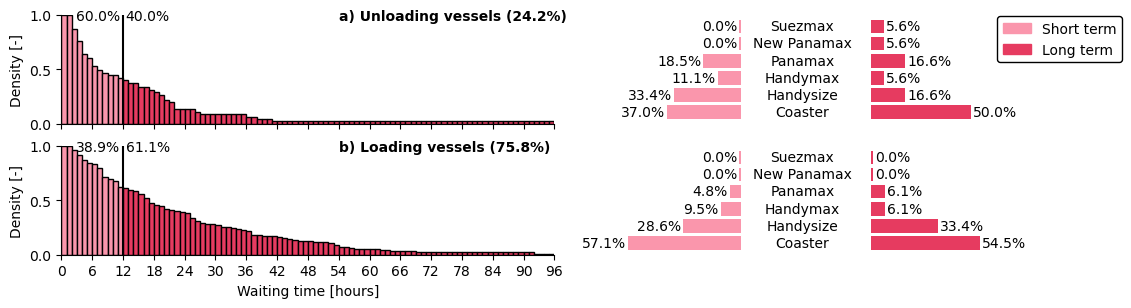

In [94]:
fig = plt.figure()

gs1 = GridSpec(2, 31,bottom=0.25,top=0.75,left=-0.5,right=1)
ax1 = fig.add_subplot(gs1[0, 0:16])
ax2 = fig.add_subplot(gs1[0, 18:22])
ax3 = fig.add_subplot(gs1[0, 26:30])
ax4 = fig.add_subplot(gs1[1, 0:16])
ax5 = fig.add_subplot(gs1[1, 18:22])
ax6 = fig.add_subplot(gs1[1, 26:30])

df = discrepancy_data+full_model_comparison_df.Waiting_due_to_priority_inbound
unloading_df = df[unloading_df.index]

N, bins, patches = ax1.hist([time.total_seconds()/3600 for time in unloading_df[unloading_df > pd.Timedelta(0,'s')]],edgecolor='k',bins=np.arange(0,1000,1),cumulative=-1,density=True,facecolor='#fa96ac',)
for i,_bin in enumerate(np.arange(0,100,1)):
    if _bin > 11:
        patches[i].set_facecolor('#e63b60')

ax1.set_xlim(0,96)
ax1.set_xticks(np.arange(0,100,6))
ax1.set_xticklabels(np.arange(0,100,6))
ax1.set_ylim(0,1)
ax1.set_ylabel('Density [-]');

y = [0,1,2,3,4,5]
xunloading_short = []
xunloading_long = []
for shiptype in ['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax']:
    xunloading_short.append(len(unloading_df.loc[unloading_df.keys().isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)][(unloading_df > pd.Timedelta(0,'s'))&(unloading_df <= pd.Timedelta(12,'h'))]))
    xunloading_long.append(len(unloading_df.loc[unloading_df.keys().isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)][unloading_df > pd.Timedelta(12,'h')]))

xunloading_shorts = xunloading_short/np.sum(xunloading_short)+0.01
xunloading_longs = xunloading_long/np.sum(xunloading_long)+0.01
    
ax2.barh(y, xunloading_shorts, align='center', color='#fa96ac')
ax2.set_xticklabels([]);
ax2.set_yticklabels([]);
ax3.barh(y, xunloading_longs, align='center', color='#e63b60')
ax3.set_xticklabels([]);
ax3.set_yticklabels([]); 
ax2.axis('off')
ax3.axis('off')

loading_df = df[loading_df.index]
N, bins, patches = ax4.hist([time.total_seconds()/3600 for time in loading_df[loading_df > pd.Timedelta(0,'s')]],edgecolor='k',bins=np.arange(0,1000,1),cumulative=-1,density=True,facecolor='#fa96ac',)
for i,_bin in enumerate(np.arange(0,100,1)):
    if _bin > 11:
        patches[i].set_facecolor('#e63b60')

ax4.set_xlim(0,96)
ax4.set_xticks(np.arange(0,100,6))
ax4.set_xticklabels(np.arange(0,100,6))
ax4.set_ylim(0,1)
ax4.set_xlabel('Waiting time [hours]')
ax4.set_ylabel('Density [-]')

y = [0,1,2,3,4,5]
xloading_short = []
xloading_long = []
for shiptype in ['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax']:
    xloading_short.append(len(loading_df.loc[loading_df.keys().isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)][(loading_df > pd.Timedelta(0,'s'))&(loading_df <= pd.Timedelta(12,'h'))]))
    xloading_long.append(len(loading_df.loc[loading_df.keys().isin(shiptype_df[shiptype_df.Shiptype == shiptype].index)][loading_df > pd.Timedelta(12,'h')]))

xloading_shorts = xloading_short/np.sum(xloading_short)+0.01
xloading_longs = xloading_long/np.sum(xloading_long)+0.01

ax5.barh(y, xloading_shorts, align='center', color='#fa96ac')
ax5.set_xticklabels([]);
ax5.set_yticklabels([]);
ax6.barh(y, xloading_longs, align='center', color='#e63b60')
ax6.set_xticklabels([]);
ax6.set_yticklabels([]);
ax5.axis('off')
ax6.axis('off')
max_x = np.max([ax2.get_xlim()[1],ax3.get_xlim()[1],ax5.get_xlim()[1],ax6.get_xlim()[1]])
for ax in [ax2,ax3,ax5,ax6]:
    ax.set_xlim(0,max_x)
    
ax2.invert_xaxis()
ax5.invert_xaxis()
ax1.set_xticklabels([])
ax1.spines[['right', 'top']].set_visible(False)
ax4.spines[['right', 'top']].set_visible(False)

for loc,(label,label_short,label_long) in enumerate(zip(['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'],xunloading_shorts,xunloading_longs)):
    percentage_short = np.round((label_short-0.01)*100,1)
    percentage_long = np.round((label_long-0.01)*100,1)
    if percentage_long == 16.7:
        percentage_long = 16.6
    if percentage_long == 33.3:
        percentage_long = 33.4
    if percentage_short == 16.7:
        percentage_short = 16.6
    if percentage_short == 33.3:
        percentage_short = 33.4
    ax3.text(-0.35,loc,label,horizontalalignment='center',verticalalignment='center')
    ax2.text(label_short+0.01,loc,str(percentage_short)+'%',horizontalalignment='right',verticalalignment='center')
    ax3.text(label_long+0.01,loc,str(percentage_long)+'%',horizontalalignment='left',verticalalignment='center')
for loc,(label,label_short,label_long) in enumerate(zip(['Coaster','Handysize','Handymax','Panamax','New Panamax','Suezmax'],xloading_shorts,xloading_longs)):
    percentage_short = np.round((label_short-0.01)*100,1)
    percentage_long = np.round((label_long-0.01)*100,1)
    if percentage_long == 16.7:
        percentage_long = 16.6
    if percentage_long == 33.3:
        percentage_long = 33.4   
    if percentage_short == 16.7:
        percentage_short = 16.6
    if percentage_short == 33.3:
        percentage_short = 33.4
    ax6.text(-0.35,loc,label,horizontalalignment='center',verticalalignment='center')
    ax5.text(label_short+0.01,loc,str(percentage_short)+'%',horizontalalignment='right',verticalalignment='center')
    ax6.text(label_long+0.01,loc,str(percentage_long)+'%',horizontalalignment='left',verticalalignment='center')
    
ax1.text(54,0.95,'a) Unloading vessels ('+str(np.round(unloading_df.sum()/(unloading_df.sum()+loading_df.sum())*100,1))+'%)',weight='bold',horizontalalignment='left')
ax4.text(54,0.95,'b) Loading vessels ('+str(np.round(loading_df.sum()/(unloading_df.sum()+loading_df.sum())*100,1))+'%)',weight='bold',horizontalalignment='left')
legend1, = ax1.fill([0,0,0,0],[0,0,0,0],color='#fa96ac')
legend2, = ax1.fill([0,0,0,0],[0,0,0,0],color='#e63b60')
ax1.axvline(12,color='k')
ax4.axvline(12,color='k')
ax1.text(11.5,0.95,str(np.round((np.sum(xunloading_short)/(np.sum(xunloading_short)+np.sum(xunloading_long)))*100,1))+'%',horizontalalignment='right')
ax1.text(12.5,0.95,str(np.round((np.sum(xunloading_long)/(np.sum(xunloading_short)+np.sum(xunloading_long)))*100,1))+'%',horizontalalignment='left')
ax4.text(11.5,0.95,str(np.round((np.sum(xloading_short)/(np.sum(xloading_short)+np.sum(xloading_long)))*100,1))+'%',horizontalalignment='right')
ax4.text(12.5,0.95,str(np.round((np.sum(xloading_long)/(np.sum(xloading_short)+np.sum(xloading_long)))*100,1))+'%',horizontalalignment='left')
ax3.legend([legend1,legend2],['Short term','Long term'],bbox_to_anchor=[1.0,1.05],edgecolor='k', framealpha=1)
plt.show();

In [95]:
fig.savefig(output_path+'\\02_Figures'+'\\Figure_10_Discrepancies.pdf',format='pdf',dpi=500,bbox_inches='tight')

In [90]:
18.5+11.1+33.4+37.0

100.0

In [88]:
5.6+5.6+16.6+5.6+16.6+50

100.0

In [91]:
4.8+9.5+28.6+57.1

100.0

In [92]:
6.1+6.1+33.3+54.5

100.0